In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import healpy as hp
from scipy.stats import binned_statistic
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline
import time
import sys
import sqlite3
import json
import glob
from natsort import natsorted

In [2]:
# taken from Peter and Lynne's original notebooks
# https://github.com/rhiannonlynne/notebooks/blob/master/Template%20Generation.ipynb
# https://github.com/yoachim/22_Scratch/blob/main/template_metrics/template_stuff.ipynb

# get just the first year of observations

In [3]:
baseline_db = "baseline_v3.0_10yrs.db"
year1_fname = 'first_year_{}.db'.format(baseline_db.split(".db")[0])

nside = 256
# nside = 32

# save_dir = "remove_no_template_results_{}".format(nside)
save_dir = "remove_no_template_results_{}_noDD".format(nside)

In [4]:
opsim_fname = year1_fname
opsim_fname

'first_year_baseline_v3.0_10yrs.db'

In [5]:
opsdb = maf.OpsimDatabase(opsim_fname)
runName = os.path.split(opsdb)[-1].replace('.db', '')
opsdb,runName

('first_year_baseline_v3.0_10yrs.db', 'first_year_baseline_v3.0_10yrs')

In [6]:
# template gen timescales to test
tscales = [28,28*4,28*6]

In [7]:
if not os.path.isfile(year1_fname): 
    print("get year 1 observations")
    conn = sqlite3.connect(baseline_db)
    df = pd.read_sql('select * from observations;', conn)
    df_year1 = df[df["night"]<night_max]
    conn.close()

    # open up a connection to a new database
    conn = sqlite3.connect(year1_fname)
    df_year1.to_sql('observations', conn, index=False, if_exists='replace')
    conn.close()
    
else:
    conn = sqlite3.connect(year1_fname)
    df_year1 = pd.read_sql('select * from observations;', conn)
    conn.close()

# Load the saved template metric data and combine the chunks

In [8]:
def load_template_metric(runName,
                         metric="doAllTemplateMetrics_Count",
                         slicer = "HEAL",
                         filt="all",save_dir="remove_no_template_results_32",
                         operation="sum",
                        print_flag=False):
    
    """
    The doAllTemplateMetrics works by running metrics on batches of observations made between nights on which templates were generated.
    This function loads the all the files of a previously run metric.
    An operation can be performed on all of these reloaded metrics,
    e.g. the total number of visits from the "Count" metric can be found by using "sum".
    
    The save_dir is searched for files matching some pattern: runName, metric, filt, slicer
    """
        
    # glob all files in the save_dir
    files = glob.glob("{}/*npz".format(save_dir))
    
    # select the relevant metric files using the patterns
    if filt=="all": # select all filters
        _files = [x for x in files if (runName in x) 
                 & (metric in x)
                 & (slicer in x)
                 & ~(("_u_".format(filt) in x)
                 | ("_g_".format(filt) in x)
                 | ("_r_".format(filt) in x)
                 | ("_i_".format(filt) in x)
                 | ("_z_".format(filt) in x)
                 | ("_y_".format(filt) in x))
                 ]                
    else:
        _files = [x for x in files if (runName in x) 
                  & (metric in x) 
                  & (slicer in x)
                  & ("_{}_".format(filt) in x)]
        
    _files = natsorted(_files) # ensure files are in numerical order (based on the template generation night considered)
    if print_flag:
        print(_files)
    print(len(_files))

    # load all these metric files
    metric_bundle = []
    for x in _files:
        metric_bundle.append(maf.MetricBundle.load(x))

    # retrieve data/mask for all the masked arrays
    # each value in data corresponds to the metric value for some slice point
    data = [mb.metricValues.data for mb in metric_bundle]
    mask = [mb.metricValues.mask for mb in metric_bundle]
    metric_data = np.ma.array(data, mask=mask)

    if operation == "min":
        # find the minimum of all constituent metrics
        metric_vals = metric_data.min(axis=0)
    elif operation == "sum":
        # find the sum of all constituent metrics
        metric_vals = metric_data.sum(axis=0)
    else:
        # return the untouched multidimensional masked array if you want to look at it separately
        print("no operation performed")
        metric_vals = metric_data
    
    # replace the masked values with nan
    metric_vals.fill_value = np.nan
    
    return metric_vals

In [21]:
def skymap_plot_Night(metric_plot, title, 
                      template_nights,
                      _min=None, _max=None):

    #plot the skymap
    x = hp.mollview(metric_plot, title=title, 
                    min = _min, max=_max,
                    cbar = None)
    hp.graticule()

    # customise the colorbar
    fig = plt.gcf()
    ax = plt.gca()
    image = ax.get_images()[0]
    # cbar = fig.colorbar(image, ax=ax, orientation = "horizontal",aspect = 30, location = "bottom")
    cbar = fig.colorbar(image, ax=ax, orientation = "horizontal", shrink = 0.5, location = "bottom",
                       pad = 0.05)

    # fix the ticks at 0 nights and at the end?
    ticks = template_nights[:-1]
    cbar.set_ticks(ticks)
    cbar.set_ticklabels(ticks)
    
    # set vmin, vmax to get constant scale for comparision?

    fname = "{}.png".format("".join(title.split(" ")))
    plt.savefig(fname, facecolor="w", transparent=True, bbox_inches="tight")
    
    plt.show()

In [22]:
def skymap_plot(metric_plot, title):

    #plot the skymap
    x = hp.mollview(metric_plot, title=title, 
                    cbar = None)
    hp.graticule()

    # customise the colorbar
    fig = plt.gcf()
    ax = plt.gca()
    image = ax.get_images()[0]
    # cbar = fig.colorbar(image, ax=ax, orientation = "horizontal",aspect = 30, location = "bottom")
    cbar = fig.colorbar(image, ax=ax, orientation = "horizontal", shrink = 0.5, location = "bottom",
                       pad = 0.05)

    fname = "{}.png".format("".join(title.split(" ")))
    plt.savefig(fname, facecolor="w", transparent=True, bbox_inches="tight")

    plt.show()

In [11]:
def histogram_plot(metric_plot,bins="auto",title="hist_plot",pix_area=None):
    
    fig = plt.figure()
    gs = gridspec.GridSpec(1,1)
    ax1 = plt.subplot(gs[0,0])

    n,b,p = ax1.hist(metric_plot, bins = bins, histtype = "step")

    # ax1.axvline(np.median(data),c="C{}".format(i))

    # total area
    print(sum(n)*pix_area)

    
    ### CONVERT UNITS OR SCALE AXIS?
    if pix_area:
        # scale the y axis to get sky area
        y_vals = ax1.get_yticks()
        ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])
        ax1.set_ylabel("area (square degrees)")
    else:
        ax1.set_ylabel("number of healpixels")

    ax1.set_xlabel("metric number")

    plt.title("{} {}".format(_runName,m))

    plt.show()

first_year_baseline_v3_0_10yrs_nside-256 CountMetric all
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_nside-256_CountMetric_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes


0.0 180.0 -180.0 180.0


(786432,)


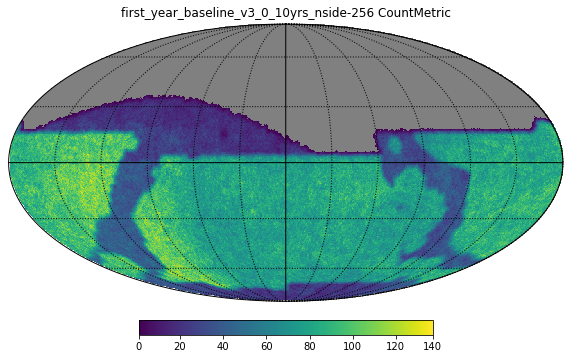

28006.651926315553


/var/folders/6r/3460lbq91j9402dmmk71v61m0000gt/T/ipykernel_18281/2638790992.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])


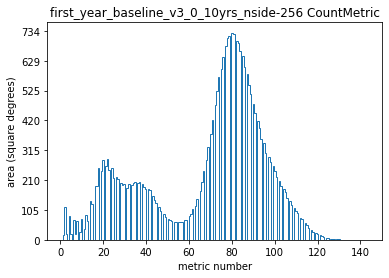

first_year_baseline_v3_0_10yrs_nside-256 PairMetric all
['remove_no_template_results_256_noDD/first_year_baseline_v3_0_10yrs_nside-256_PairMetric_night_lt_365_and_note_not_like_DD_HEAL.npz']
1
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes


0.0 180.0 -180.0 180.0


(786432,)


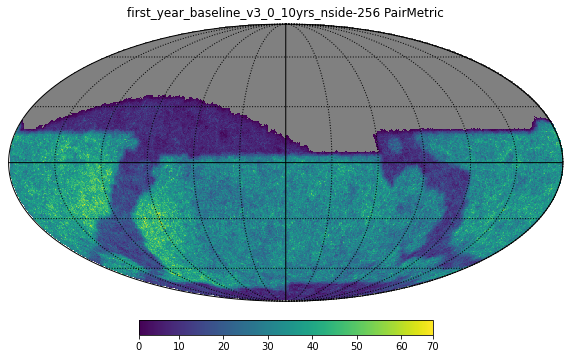

27972.135975156245


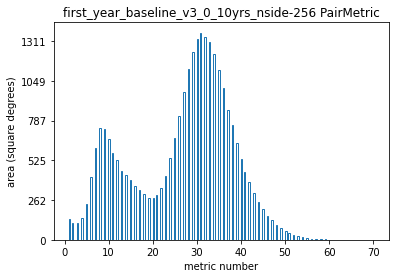

In [12]:
# plot the results of the default baseline simulation

### TODO
# MAKE SURE AN OPERATION IS NOT PERFORMED HERE
# if len(_files)==1 return just the metric?
# Could be fine as the sum over a len 1 array is unchanged

for m in ["CountMetric","PairMetric"]:
    filt = "all"
    pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

    _runName = "{}_nside-{}".format(runName,nside).replace(".","_")
    print(_runName,m,filt)
    metric_plot = load_template_metric(_runName,
                                       metric=m,
                                       filt=filt, print_flag=True,
                                      save_dir = save_dir)
    print(metric_plot.shape)

    title = "{} {}".format(_runName,m)
    skymap_plot(metric_plot, title = title)
    histogram_plot(metric_plot,bins = 200,title=title,pix_area=pix_area)

In [13]:
### TODO
# double check the area in the pair histogram

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Night r
14
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSID

0.0 180.0 -180.0 180.0


(786432,)


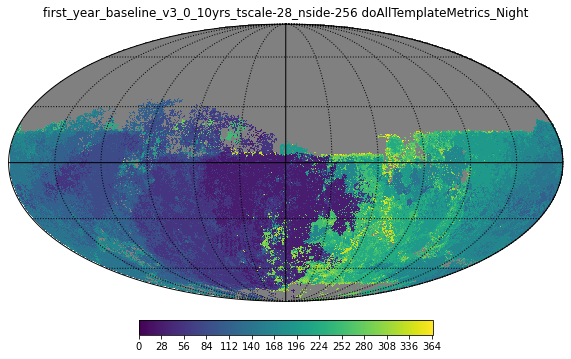

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Night r
4
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes


0.0 180.0 -180.0 180.0


(786432,)


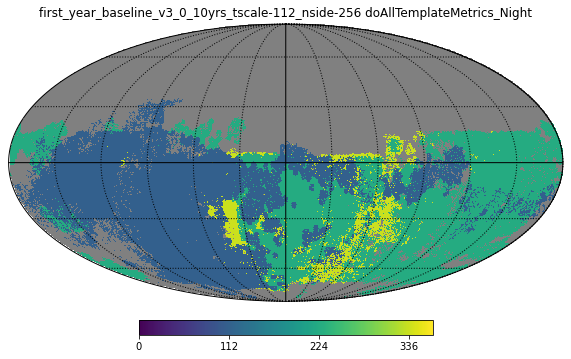

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Night r
3
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
(786432,)


0.0 180.0 -180.0 180.0


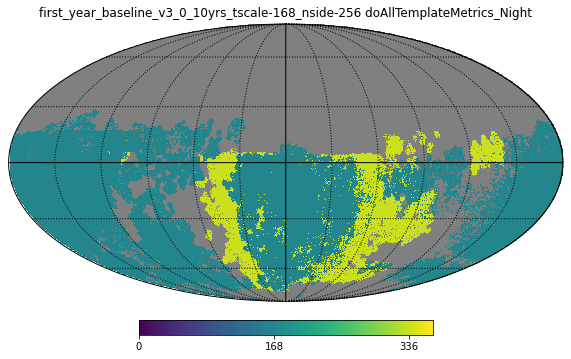

In [24]:
m = "doAllTemplateMetrics_Night"
filt = "r"

for tscale in tscales:
    
    # divide year 1 into chunks of a given template_timescale
    template_nights = np.arange(0,365+tscale,tscale)
    template_nights[-1] = 365 # consider only the first year
        
    _runName = "{}_tscale-{}_nside-{}".format(runName,tscale,nside).replace(".","_")
    print(runName,m,filt)
    metric_plot = load_template_metric(_runName,
                                       metric=m,
                                       filt=filt,
                                       operation="min",save_dir = save_dir)
    print(metric_plot.shape)
    
    skymap_plot_Night(metric_plot, title = "{} {}".format(_runName,m), template_nights = template_nights,
                      _min = 0, _max = 365)
    
#     break

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Pairs r
14
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSID

0.0 180.0 -180.0 180.0


(786432,)


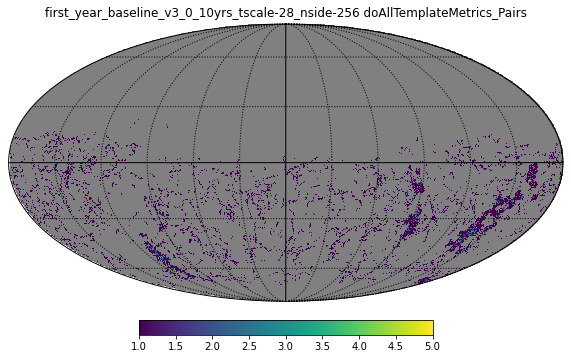

2360.146186186627


/var/folders/6r/3460lbq91j9402dmmk71v61m0000gt/T/ipykernel_18281/2638790992.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])


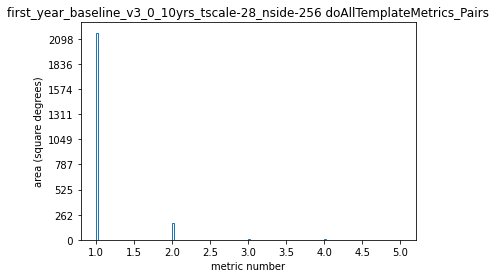

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Pairs r
4
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
(786432,)


0.0 180.0 -180.0 180.0


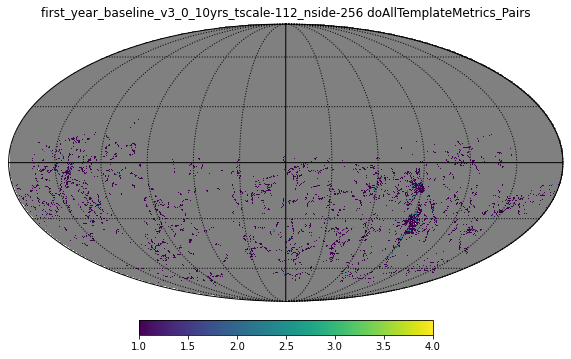

1278.4540450679099


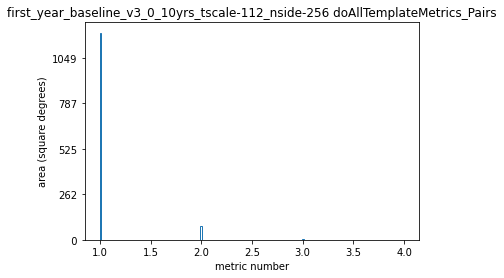

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Pairs r
3
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes


0.0 180.0 -180.0 180.0


(786432,)


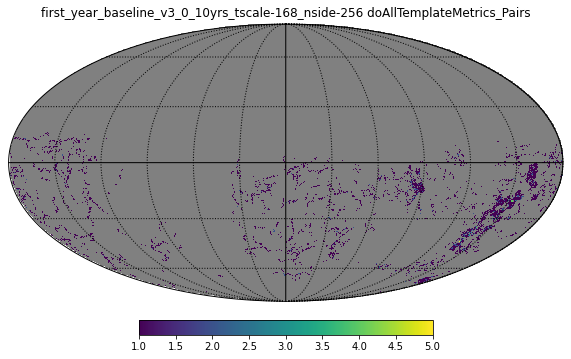

1241.787403942747


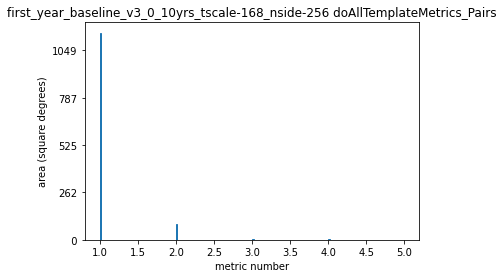

In [28]:
m = "doAllTemplateMetrics_Pairs"
# m = "PairMetric"
filt = "r"
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

for tscale in tscales:
        
    _runName = "{}_tscale-{}_nside-{}".format(runName,tscale,nside).replace(".","_")
    print(runName,m,filt)
    metric_plot = load_template_metric(_runName,
                                       metric=m,
                                       filt=filt,save_dir = save_dir)
    print(metric_plot.shape)
    
    title = "{} {}".format(_runName,m)
    skymap_plot(metric_plot, title = title)
    histogram_plot(metric_plot,bins=200,title=title,pix_area=pix_area)
        
#     break

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Count all
14
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NS

0.0 180.0 -180.0 180.0


(786432,)


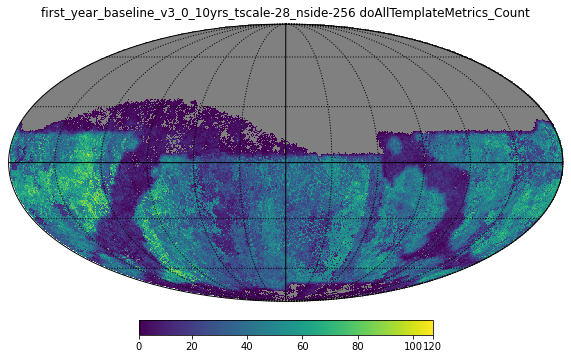

26704.855026740206


/var/folders/6r/3460lbq91j9402dmmk71v61m0000gt/T/ipykernel_18281/2638790992.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])


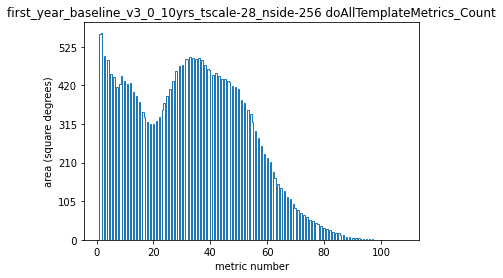

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Count all
4
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes


0.0 180.0 -180.0 180.0


(786432,)


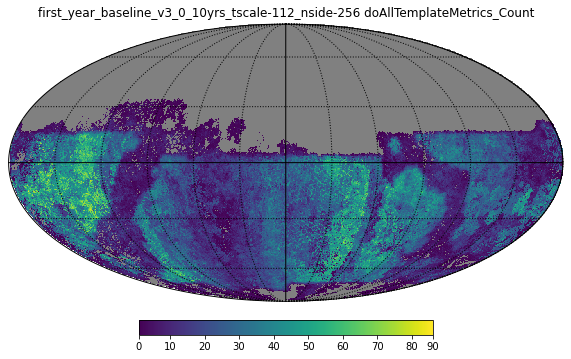

25477.178247207572


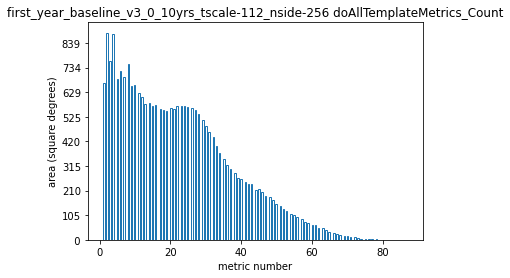

first_year_baseline_v3.0_10yrs doAllTemplateMetrics_Count all
3
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
(786432,)


0.0 180.0 -180.0 180.0


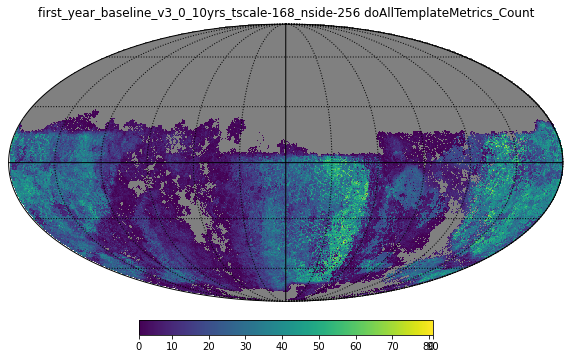

23748.23333807257


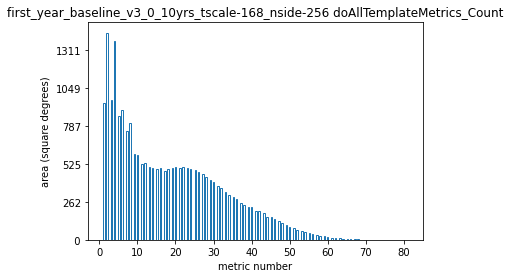

In [16]:
m = "doAllTemplateMetrics_Count"
filt = "all"
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

for tscale in tscales:
        
    _runName = "{}_tscale-{}_nside-{}".format(runName,tscale,nside).replace(".","_")
    print(runName,m,filt)
    metric_plot = load_template_metric(_runName,
                                       metric=m,
                                       filt=filt,save_dir = save_dir)
    print(metric_plot.shape)
    
    title = "{} {}".format(_runName,m)
    skymap_plot(metric_plot, title = title)
    histogram_plot(metric_plot,bins = 200,title=title,pix_area=pix_area)
        
#     break